# Basic Imports

Here, we import the basic packages like **pandas** and **numpy** for I/O and Linear Algebra. Link to the documentation of the packages can be found here:
* [numpy](https://numpy.org/doc/stable/)
* [pandas](https://pandas.pydata.org/docs/reference/index.html#api)
* [os](https://docs.python.org/3/library/os.html)

In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


**Initialising the Fake News Dataset into a DataFrame**

I tried Training using the full corpus but even Kaggle Kernels ran out of memory, so I've shortened both the corpus to only have 5000 instances of each class

In [2]:
fakedataset = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")
fake = fakedataset[:5000]

**Initialising the Real News Dataset into a DataFrame**

In [3]:
realdataset = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")
real = realdataset[:5000]

# Pre-Processing

**Adding Classes to the Datasets**

The dataset doesn't have any classes associated with it, so to enable Supervised Learning I've given a class of 1 to real news and 0 to fake news

In [4]:
real["class"] = 1
fake["class"] = 0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Concatenating Text and Title into a Single Column (to improve performance)**

Just Predicting with the Title/Headlines wouldn't give good results so, I've Concatenated both (Title and Text) into a single column of the individual dataframes. Also, I haven't tried to exploit the relationship between subjects so I've dropped those columns.

In [5]:
real["text"] = real["title"] + " " + real["text"]
fake["text"] = fake["title"] + " " + fake["text"]

real.drop(["subject", "date", "title"], axis = 1)
fake.drop(["subject", "date", "title"], axis = 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0
...,...,...
4995,FBI Warns Republicans: Do Not Leak Clinton Em...,0
4996,Justice Department Announces It Will No Longe...,0
4997,WATCH: S.E. Cupp Destroys Trump Adviser’s ‘Fa...,0
4998,WATCH: Fox Hosts Claim Hillary Has Brain Dama...,0


**Creating a Single DataFrame**

Joined both dataframes to just have a single dataframe

In [6]:
dataset = real.append(fake, ignore_index = True)

In [7]:
del real, fake

**!! Download stopwords and punkt from nltk**

In [8]:
import nltk

nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**Performing basic pre-processing on the Corpus**

Here, I've used the [Porter Stemmer](https://www.nltk.org/howto/stem.html) from the nltk module to stem the words. Also, I've converted everything into lowercase and removed stopwords.

In [9]:
import re
import string
stopwords = nltk.corpus.stopwords.words('english')
stemmer = nltk.PorterStemmer()

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

dataset['body_len'] = dataset['text'].apply(lambda x: len(x) - x.count(" "))
dataset['punct%'] = dataset['text'].apply(lambda x: count_punct(x))

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [stemmer.stem(word) for word in tokens if word not in stopwords]
    return text
    

**Creating Train, Test and Split Datasets**

Here, I've used the [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function from sklearn to create random train and test subsets of the dataset. 

In [10]:
from sklearn.model_selection import train_test_split

X=dataset[['text', 'body_len', 'punct%']]
y=dataset['class']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4, random_state=42)

**Vectorising the Corpus using TfidfVectorizer**

We, use the [TfidfVectoriser](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer) from sklearn module to transform the matrix into a tf-idf representation. This is representation is commonly used in document classification and information retrieval 

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['text'])

tfidf_train = tfidf_vect_fit.transform(X_train['text'])
tfidf_test = tfidf_vect_fit.transform(X_test['text'])

X_train_vect = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,body_len,punct%,0,1,2,3,4,5,6,7,...,55054,55055,55056,55057,55058,55059,55060,55061,55062,55063
0,1766,1.8,0.014404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2928,2.7,0.008197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2249,2.0,0.010530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3483,1.9,0.005983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,338,2.1,0.028734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Importing Necessary Packages from sklearn**

We use the following functions for building our model:
* [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) : A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.
* [precision_recall_fscore_support](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support) : To compute precision, recall, F-measure and support for each class
* [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) : To compute the accuracy classification score
* [matplotlib](https://matplotlib.org/api/index.html)
* [seaborn](https://seaborn.pydata.org/api.html)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score as acs
import matplotlib.pyplot as plt
import seaborn as sns

# Training The Model

We build a RandomForestClassifier instance and then train it on our training subset and then evaluate it over our test subset. And then make a confusion matrix using the [heatmap function](https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap) from seaborn

Precision: 1.0 / Recall: 0.997 / F1-Score: 0.998 / Accuracy: 0.998


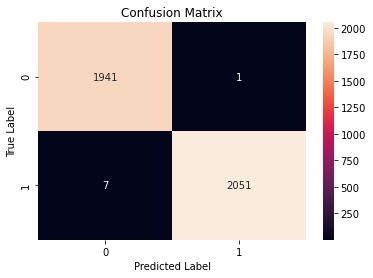

In [13]:
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

rf_model = rf.fit(X_train_vect, y_train)

y_pred = rf_model.predict(X_test_vect)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label=1, average='binary')
print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round(fscore,3), round(acs(y_test,y_pred), 3)))

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
class_label = [0, 1]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
